## Algebraic expressions Dataset

This dataset consists of arithmetic expressions according to the following regular tree grammar, adapted from [Kusner, Paige, and Hernandez-Lobato (2017)](http://proceedings.mlr.press/v70/kusner17a/kusner17a.pdf).

```
S -> +(S, S)
S -> *(S, S)
S -> /(S, S)
S -> 'sin(' S ')'
S -> 'exp(' S ')'
S -> 'x()'
S -> '1()'
S -> '2()'
S -> '3()'
```

Note that these expressions define functions with one variable (namely x).

Further note that we do not sample all possible expressions but only a tiny subset, following Kusner's work. See below for the details of the sampler.

In [1]:
dataset_name = 'expressions'

# set up grammar
import tesae.tree_grammar as tree_grammar
import edist.tree_utils as tree_utils

alphabet = {'+' : 2, '*' : 2, '/' : 2, 'sin' : 1, 'exp' : 1, 'x' : 0, '1' : 0, '2' : 0, '3' : 0}
nonterminals = ['S']
start    = 'S'
rules    = { 'S' : [
    ('+', ['S', 'S']),
    ('*', ['S', 'S']),
    ('/', ['S', 'S']),
    ('sin', ['S']),
    ('exp', ['S']),
    ('x', []),
    ('1', []),
    ('2', []),
    ('3', [])
]}

grammar = tree_grammar.TreeGrammar(alphabet, nonterminals, start, rules)

In [2]:
# set up a function to sample data
import random
import tesae.tree as tree
def sample_tree():
    # every expression consists of three parts that are added,
    # first an expression of two numbers or xs, either +, *, or /
    # second a number, x, or sin or exp thereof
    # third, a number, x, a binary expression thereof, or sin or exp
    # of these options.
    # In other words, the actual data is generated by a simpler
    # grammar of the form:
    # Expression -> Binary + Unary + Combination
    # Binary -> Literal | Literal + Literal | Literal * Literal | Literal / Literal
    # Unary -> Literal | exp(Literal) | sin(Literal)
    # Combination -> Binary | Unary | exp(Binary) | sin(Binary)
    # Literal -> 1 | 2 | 3 | x

    # start off by sampling the binary
    binary = sample_binary()
    # then the unary
    unary  = sample_unary()
    # then the combination
    combination = sample_combination()
    # build the combined expression
    expr = tree.Tree('+', [binary, tree.Tree('+', [unary, combination])])
    return expr.to_list_format()
    
def sample_combination():
    r = random.randrange(4)
    if r == 0:
        return sample_binary()
    if r == 1:
        return sample_unary()
    children = [sample_binary()]
    if r == 2:
        return tree.Tree('exp', children)
    if r == 3:
        return tree.Tree('sin', children)

def sample_binary():
    r = random.randrange(4)
    if r == 0:
        return sample_literal()
    left = sample_literal()
    right = sample_literal()
    children = [left, right]
    if r == 1:
        return tree.Tree('+', children)
    if r == 2:
        return tree.Tree('*', children)
    if r == 3:
        return tree.Tree('/', children)

def sample_unary():
    r = random.randrange(3)
    if r == 0:
        return sample_literal()
    children = [sample_literal()]
    if r == 1:
        return tree.Tree('exp', children)
    if r == 2:
        return tree.Tree('sin', children)

def sample_literal():
    r = random.randrange(4)
    return tree.Tree('123x'[r])

# also set up a function to print trees as more intuitive strings
def to_algebraic_string(nodes, adj, i = 0):
    if nodes[i] == '+' or nodes[i] == '*' or nodes[i] == '/':
        return to_algebraic_string(nodes, adj, adj[i][0]) + ' ' + nodes[i] + ' ' + to_algebraic_string(nodes, adj, adj[i][1])
    if nodes[i] == 'sin' or nodes[i] == 'exp':
        return nodes[i] + '(' + to_algebraic_string(nodes, adj, adj[i][0]) + ')'
    else:
        return nodes[i]

import matplotlib.pyplot as plt
import numpy as np
def evaluate(nodes, adj):
    # evaluate the functional expression on 1000 linearly spaced
    # points between -10 and 10 against the true function
    # 1/3+x+sin(x*x) as described by Kusner et al. (2017)
    x = np.linspace(-10., 10., 1000)
    y = 1. / 3. + x + np.sin(x * x)
    y_pred = evaluate_on_x(nodes, adj, x)
    # return log(1 + MSE) as suggested by Kusner et al. (2017)
    return np.log(1. + np.mean((y - y_pred) ** 2))

def evaluate_on_x(nodes, adj, x, i = 0):
    # evaluates the given expression tree on the data x,
    # starting from node i

    # evaluate children first
    children = []
    for j in adj[i]:
        children.append(evaluate_on_x(nodes, adj, x, j))
    # then evaluate the current node
    if nodes[i] == '+':
        return children[0] + children[1]
    if nodes[i] == '*':
        return children[0] * children[1]
    if nodes[i] == '/':
        return children[0] / children[1]
    if nodes[i] == 'exp':
        return np.exp(children[0])
    if nodes[i] == 'sin':
        return np.sin(children[0])
    if nodes[i] == 'x':
        return x
    if nodes[i] == '1':
        return np.ones(len(x))
    if nodes[i] == '2':
        return 2 * np.ones(len(x))
    if nodes[i] == '3':
        return 3 * np.ones(len(x))
    raise ValueError('Unknown symbol: %s' % nodes[i])

```
# we can also read data from the text file of Kusner if we want.
right_hand_sides = ['S+S', 'S*S', 'S/S', 'sinS', 'epS', 'x', '1', '2', '3', '(S)']

trees = []
avg_nodes = 0
with open('expressions_data.txt') as f:
    for expression in f:
        expression = expression.replace(' ', '').replace('exp', 'ep')[:-1]
        # parse the expression from the right into a tree
        stk = ''
        c = len(expression)
        seq = []
        while stk != 'S' or c > 0:
            found_rule = False
            for r in range(len(right_hand_sides)):
                right = right_hand_sides[r]
                if len(stk) >= len(right) and stk[:len(right)] == right:
                    stk = 'S' + stk[len(right):]
                    found_rule = True
                    seq.append(r)
                    break
            if not found_rule:
                c -= 1
                if c < 0:
                    raise ValueError('parse for %s failed with remaining stack %s' % (expression, stk))
                stk = expression[c] + stk
        seq.reverse()
        seq = list(filter(lambda r: r < len(rules['S']), seq))
        nodes, adj = grammar.produce(seq)
        trees.append((nodes, adj))
        avg_nodes += len(nodes)
print('read %d trees; average number of nodes: %g' % (len(trees), avg_nodes / len(trees)))
```

In [3]:
# sample trees for the experiment
m = 500
trees = []
for i in range(m):
    trees.append(sample_tree())

# print average tree size
avg_size = 0
for i in range(len(trees)):
    avg_size += len(trees[i][0])
avg_size /= len(trees)
print('average tree size: %g' % avg_size)

average tree size: 9.056


In [4]:
# set up experimental metadata
num_folds   = 20
num_neurons = 256
#sparsity    = 0.1
#radius      = 0.95
#regul       = 1E-5
#w_c         = 0.9
#w_j         = 0.3
#l           = 25
#v           = 0.1

param_ranges = {
    'sparsity' : (0.1, 0.5),
    'radius' : (0.5, 0.95),
    'w_c' : (0.5, 0.95),
    'w_j' : (0.3, 0.9),
    'v' : (0.1, 0.5)
}
param_options = {
    'regul' : [1E-7, 1E-5, 1E-3, 1E-1],
    'l' : [5, 10, 25, 50]
}
hyper_m = 100
random_trials = 50

models      = ['esae', 'stesae', 'tesae']

In [5]:
# perform hyper-parameter optimization via random search on a separate dataset
hyper_train_trees = []
hyper_test_trees  = []
for i in range(hyper_m):
    hyper_train_trees.append(sample_tree())
    hyper_test_trees.append(sample_tree())

import numpy as np

params = []
hyper_errors  = np.ones((len(models), random_trials))

import random
from experiment_utils import tree_rmse
import tesae.crj as crj
from tesae.echo_state_auto_encoder import ESTreeWrapper
from tesae.tree_echo_state_auto_encoder import TESAutoEncoder

for r in range(random_trials):
    print('--- random trial %d of %d --- ' % (r+1, random_trials))
    # sample a set of parameters
    param = {}
    for param_name in param_ranges:
        lo, hi = param_ranges[param_name]
        param[param_name] = random.random() * (hi - lo) + lo
    for param_name in param_options:
        options = param_options[param_name]
        param[param_name] = random.choice(options)
    params.append(param)
    # train all models with the current parameters
    for model_idx in range(len(models)):
        print(models[model_idx])
        if models[model_idx] == 'esae':
            # echo state auto encoder
            model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
            model.fit(hyper_train_trees)
        elif models[model_idx] == 'stesae':
            # tree echo state auto encoder with shared reservoir
            W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
            model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
            model.fit_svm(hyper_train_trees)
        elif models[model_idx] == 'tesae':
            # tree echo state auto encoder
            model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
            model.fit_svm(hyper_train_trees)
        else:
            raise ValueError('unknown model: %s' % models[model_idx] )

        hyper_errors[model_idx, r] = tree_rmse(model, hyper_test_trees)

# select the best parameters for each model
opt_param = []
for model_idx in range(len(models)):
    r_opt = np.argmin(hyper_errors[model_idx, :])
    opt_param.append(params[r_opt])
    print('optimal parameters for model %s with error %g:' % (models[model_idx], hyper_errors[model_idx, r_opt]))
    print(opt_param[model_idx])

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


--- random trial 1 of 50 --- 
esae
stesae
tesae
--- random trial 2 of 50 --- 
esae
stesae
tesae
--- random trial 3 of 50 --- 
esae
stesae
tesae
--- random trial 4 of 50 --- 
esae
stesae
tesae
--- random trial 5 of 50 --- 
esae
stesae
tesae
--- random trial 6 of 50 --- 
esae
stesae
tesae
--- random trial 7 of 50 --- 
esae
stesae
tesae
--- random trial 8 of 50 --- 
esae
stesae
tesae
--- random trial 9 of 50 --- 
esae
stesae
tesae
--- random trial 10 of 50 --- 
esae
stesae
tesae
--- random trial 11 of 50 --- 
esae
stesae
tesae
--- random trial 12 of 50 --- 
esae
stesae
tesae
--- random trial 13 of 50 --- 
esae
stesae
tesae
--- random trial 14 of 50 --- 
esae
stesae
tesae
--- random trial 15 of 50 --- 
esae
stesae
tesae
--- random trial 16 of 50 --- 
esae
stesae
tesae
--- random trial 17 of 50 --- 
esae
stesae
tesae
--- random trial 18 of 50 --- 
esae
stesae
tesae
--- random trial 19 of 50 --- 
esae
stesae
tesae
--- random trial 20 of 50 --- 
esae
stesae
tesae
--- random trial 21 of 50 ---

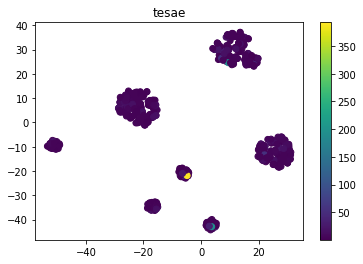

In [6]:
# reduce to two dimensions via t-SNE
from sklearn.manifold import TSNE

# set up a TES-AE model with optimal parameters
model_idx = 2
param = opt_param[model_idx]
model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])

# encode all trees and compute their evaluation
H = []
c = np.zeros(m)
for i in range(len(trees)):
    _, h = model.encode(*trees[i])
    H.append(h)
    c[i] = evaluate(*trees[i])
H = np.stack(H, axis=0)

H_lo = TSNE(n_components=2).fit_transform(H)

# visualize
import matplotlib.pyplot as plt
plt.scatter(H_lo[:, 0], H_lo[:, 1], c = c)
plt.colorbar()
plt.title(models[model_idx])
plt.show()
# save the low dimensional coding with evaluation
# to csv
np.savetxt('results/%s_%s_code_space.csv' % (dataset_name, models[model_idx]), np.concatenate([H_lo, np.expand_dims(c, 1)], axis=1), delimiter='\t', header='x\ty\tc', fmt='%g', comments = '')

In [8]:
# do a clustering on reduced TESAE encodings
import edist.tree_utils as tree_utils
from sklearn.cluster import KMeans

K = 7
kmeans = KMeans(n_clusters = K)
kmeans.fit(H_lo)
# print the trees according to their cluster labels
for k in range(K):
    print('---- cluster %d (around %g, %g) ----' % (k, kmeans.cluster_centers_[k, 0], kmeans.cluster_centers_[k, 1]))
    for i in np.where(kmeans.labels_ == k)[0]:
        print(tree_utils.tree_to_string(*trees[i]))

---- cluster 0 (around -16.727, -34.5696) ----
+(3, +(x, 1))
+(3, +(exp(x), exp(*(1, x))))
+(3, +(exp(3), sin(1)))
+(3, +(exp(2), sin(*(2, 2))))
+(3, +(exp(1), exp(2)))
+(3, +(3, sin(x)))
+(3, +(sin(1), exp(3)))
+(3, +(sin(x), /(1, 3)))
+(3, +(exp(x), exp(*(x, 1))))
+(3, +(sin(x), exp(+(1, 3))))
+(3, +(exp(x), exp(1)))
+(3, +(exp(x), exp(x)))
+(3, +(exp(2), sin(+(2, 2))))
+(3, +(1, exp(/(1, 3))))
+(3, +(1, exp(*(1, 2))))
+(3, +(sin(x), exp(+(3, 2))))
+(3, +(x, sin(+(x, x))))
+(3, +(exp(x), sin(2)))
+(3, +(sin(1), exp(x)))
+(3, +(3, exp(*(3, 1))))
+(3, +(sin(1), sin(/(x, 1))))
+(3, +(exp(1), exp(+(x, 3))))
+(3, +(exp(x), sin(2)))
+(3, +(x, *(1, 2)))
+(3, +(exp(1), sin(1)))
+(3, +(3, exp(1)))
+(3, +(exp(2), exp(3)))
+(3, +(x, sin(2)))
+(3, +(sin(1), sin(1)))
+(3, +(exp(1), 2))
+(3, +(exp(x), exp(/(1, 2))))
+(3, +(sin(2), x))
---- cluster 1 (around -21.9301, 6.26879) ----
+(+(3, 2), +(sin(2), sin(3)))
+(+(3, x), +(1, sin(+(1, 1))))
+(+(3, x), +(exp(2), sin(2)))
+(+(x, 2), +(exp(3), exp(*(

In [19]:
# perform a crossvalidation experiment
import time
import numpy as np
from sklearn.model_selection import KFold
from experiment_utils import tree_rmse
import tesae.crj as crj
from tesae.echo_state_auto_encoder import ESTreeWrapper
from tesae.tree_echo_state_auto_encoder import TESAutoEncoder

# set up crossvalidation object
cv = KFold(n_splits=num_folds, shuffle=True)

# set up array for errors
errors_train = np.zeros((len(models), num_folds))
errors_test  = np.zeros((len(models), num_folds))
valid        = np.ones((len(models), num_folds))
# set up array for runtimes
runtimes = np.zeros((len(models), num_folds))
# iterate over the folds
f = -1
for train_index, test_index in cv.split(trees):
    f += 1
    print('--- fold %d of %d ---' % (f+1, num_folds))
    trees_train = []
    for i in train_index:
        trees_train.append(trees[i])
    trees_test = []
    for i in test_index:
        trees_test.append(trees[i])

    # iterate over all models
    for model_idx in range(len(models)):
        print(models[model_idx])
        param = opt_param[model_idx]
        # set up model and train it
        start = time.time()
        if models[model_idx] == 'esae':
            # echo state auto encoder
            model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
            model.fit(trees_train)
        elif models[model_idx] == 'stesae':
            # tree echo state auto encoder with shared reservoir
            W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
            model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
            model.fit_svm(trees_train)
        elif models[model_idx] == 'tesae':
            # tree echo state auto encoder
            model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
            model.fit_svm(trees_train)
        else:
            raise ValueError('unknown model: %s' % models[model_idx] )
        runtimes[model_idx, f] = time.time() - start

        errors_train[model_idx, f] = tree_rmse(model, trees_train)
        errors_test[model_idx, f]  = tree_rmse(model, trees_test)

--- fold 1 of 20 ---
esae
stesae
tesae
--- fold 2 of 20 ---
esae
stesae
tesae
--- fold 3 of 20 ---
esae
stesae
tesae
--- fold 4 of 20 ---
esae
stesae
tesae
--- fold 5 of 20 ---
esae
stesae
tesae
--- fold 6 of 20 ---
esae
stesae
tesae
--- fold 7 of 20 ---
esae
stesae
tesae
--- fold 8 of 20 ---
esae
stesae
tesae
--- fold 9 of 20 ---
esae
stesae
tesae
--- fold 10 of 20 ---
esae
stesae
tesae
--- fold 11 of 20 ---
esae
stesae
tesae
--- fold 12 of 20 ---
esae
stesae
tesae
--- fold 13 of 20 ---
esae
stesae
tesae
--- fold 14 of 20 ---
esae
stesae
tesae
--- fold 15 of 20 ---
esae
stesae
tesae
--- fold 16 of 20 ---
esae
stesae
tesae
--- fold 17 of 20 ---
esae
stesae
tesae
--- fold 18 of 20 ---
esae
stesae
tesae
--- fold 19 of 20 ---
esae
stesae
tesae
--- fold 20 of 20 ---
esae
stesae
tesae


In [20]:
# print results
for model_idx in range(len(models)):
    print(models[model_idx])
    print('Train RMSE: %g +- %g' % (np.mean(errors_train[model_idx, :]), np.std(errors_train[model_idx, :])))
    print('Test RMSE:  %g +- %g' % (np.mean(errors_test[model_idx, :]), np.std(errors_test[model_idx, :])))
    print('Runtimes:   %g +- %g' % (np.mean(runtimes[model_idx, :]), np.std(runtimes[model_idx, :])))

esae
Train RMSE: 3.17382 +- 0.0931402
Test RMSE:  3.87337 +- 0.612382
Runtimes:   0.848714 +- 0.0141573
stesae
Train RMSE: 0.331981 +- 0.0340192
Test RMSE:  2.65199 +- 0.23013
Runtimes:   3.37274 +- 0.0974881
tesae
Train RMSE: 0.694448 +- 0.0465083
Test RMSE:  1.69358 +- 0.213946
Runtimes:   5.05589 +- 0.0641086


In [21]:
# write the results into a table
np.savetxt('results/%s_errors.csv' % dataset_name, errors_test.T, delimiter='\t', header='\t'.join(models), fmt='%g', comments = '')
np.savetxt('results/%s_runtimes.csv' % dataset_name, runtimes.T, delimiter='\t', header='\t'.join(models), fmt='%g', comments = '')

In [17]:
# perform CMA-ES in the coding space to find optimal trees for the current task
import tesae.crj as crj
from tesae.echo_state_auto_encoder import ESTreeWrapper
from tesae.tree_echo_state_auto_encoder import TESAutoEncoder
import cma
for model_idx in range(len(models)):
    print('\n--- %s ---' % models[model_idx])
    param = opt_param[model_idx]
    # set up model on the entire tree data set
    if models[model_idx] == 'esae':
        # echo state auto encoder
        model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
        model.fit(trees)
    elif models[model_idx] == 'stesae':
        # tree echo state auto encoder with shared reservoir
        W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
        model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
        model.fit_svm(trees)
    elif models[model_idx] == 'tesae':
        # tree echo state auto encoder
        model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
        model.fit_svm(trees)
    else:
        raise ValueError('unknown model: %s' % models[model_idx] )
    # encode all training trees to get a sense of the scaling
    H = []
    for i in range(len(trees)):
        _, h = model.encode(*trees[i])
        H.append(h)
    H = np.stack(H, axis=0)
    # set up objective function, starting mean, and starting standard deviation
    mu0    = np.mean(H, axis=0)
    sigma0 = np.mean(np.std(H, axis=0))
    def objective_fun(h):
        nodes, adj, *_ = model.decode(h, max_size = 15)
        try:
            return evaluate(nodes, adj)
        except ValueError as ex:
            return np.inf
    # we set the parameter so that we have the same budget as Kusner et al. (2017)
    es = cma.CMAEvolutionStrategy(mu0, sigma0, {'popsize' : 50, 'verb_disp': 1, 'maxiter' : 15})
    es.optimize(objective_fun)
    h_opt = es.result()[0]
    nodes, adj, *_ = model.decode(h_opt, max_size = 15)
    print('CMA-ES found the following optimal tree: %s with evaluation %g' % (tree_utils.tree_to_string(nodes, adj), evaluate(nodes, adj)))
    


--- esae ---
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 256 (seed=841534, Wed Jan 22 14:30:19 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 4.875613902177156e-01 1.0e+00 1.82e-01  2e-01  2e-01 0:0.8


/usr/lib/python3.7/site-packages/cma.py:2937: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x0 == str(x0):


    2    100 3.911335709216968e-01 1.0e+00 1.77e-01  2e-01  2e-01 0:2.4
    3    150 4.875613902177156e-01 1.0e+00 1.72e-01  2e-01  2e-01 0:3.6
    4    200 3.911335709216968e-01 1.0e+00 1.69e-01  2e-01  2e-01 0:4.8


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in square


    5    250 4.875613902177156e-01 1.0e+00 1.66e-01  2e-01  2e-01 0:6.3
    6    300 4.875613902177156e-01 1.0e+00 1.63e-01  2e-01  2e-01 0:7.7
    7    350 4.875613902177156e-01 1.0e+00 1.61e-01  2e-01  2e-01 0:9.1
    8    400 4.875613902177156e-01 1.0e+00 1.59e-01  2e-01  2e-01 0:10.4
    9    450 4.875613902177156e-01 1.0e+00 1.58e-01  2e-01  2e-01 0:11.8
   10    500 4.875613902177156e-01 1.0e+00 1.57e-01  2e-01  2e-01 0:13.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    550 4.875613902177156e-01 1.0e+00 1.56e-01  2e-01  2e-01 0:15.0
   12    600 4.875613902177156e-01 1.0e+00 1.55e-01  2e-01  2e-01 0:16.1
   13    650 4.875613902177156e-01 1.0e+00 1.55e-01  2e-01  2e-01 0:17.5
   14    700 4.875613902177156e-01 1.0e+00 1.54e-01  2e-01  2e-01 0:18.8
   15    750 4.875613902177156e-01 1.1e+00 1.54e-01  2e-01  2e-01 0:20.2
CMA-ES found the following optimal tree: +(x, /(1, *(1, 3))) with evaluation 0.391134

--- stesae ---
(25_w,50)-aCMA-ES (mu_w=14

In [18]:
# perform an interpolation in high dimensional space
# between an 'x' tree and an optimal point

# set up start and end point
_, start = model.encode(['x'], [[]])
end = h_opt

# perform interpolation
for alpha in np.linspace(0., 1., 11.):
    h = start * (1. - alpha) + end * alpha
    # decode
    nodes, adj, *_ = model.decode(h, max_size = 30)
    # evaluate
    print('%g: %s [%g]' % (alpha, tree_utils.tree_to_string(nodes, adj), evaluate(nodes, adj)))

0: 1 [3.56235]
0.1: +(2, +(exp(2), *(1, 1))) [4.90403]
0.2: +(2, +(exp(2), *(1, 1))) [4.90403]
0.3: +(2, +(exp(2), *(1, 1))) [4.90403]
0.4: +(2, +(exp(2), *(1, 1))) [4.90403]
0.5: +(2, +(exp(2), *(1, 1))) [4.90403]
0.6: +(2, +(exp(2), *(1, 2))) [5.04876]
0.7: +(x, +(exp(3), *(1, 2))) [6.15723]
0.8: +(2, +(exp(3), sin(+(3, 1)))) [6.15964]
0.9: +(x, +(sin(1), sin(*(x, x)))) [0.229685]
1: +(x, +(sin(3), sin(*(x, x)))) [0.0362798]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
